# Determining Dispersion In LMC's Disk 

Using the Model 2 simulation of the LMC from Besla + 2012 . 
https://ui.adsabs.harvard.edu/abs/2012MNRAS.421.2109B/abstract

In [2]:
# Importing Modules

%pylab inline
import numpy as np

# import plotting modules
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

import scipy.optimize as so


Populating the interactive namespace from numpy and matplotlib


# Functions needed for initializing disk coordinates

In [3]:
# for plotting contours
#from https://gist.github.com/adrn/3993992


def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

def density_contour(xdata, ydata, nbins_x, nbins_y, ax=None, **contour_kwargs):
    """ Create a density contour plot.
    Parameters
    ----------
    xdata : numpy.ndarray
    ydata : numpy.ndarray
    nbins_x : int
        Number of bins along x dimension
    nbins_y : int
        Number of bins along y dimension
    ax : matplotlib.Axes (optional)
        If supplied, plot the contour to this axis. Otherwise, open a new figure
    contour_kwargs : dict
        kwargs to be passed to pyplot.contour()
    """

    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), normed=True)
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

    pdf = (H*(x_bin_sizes*y_bin_sizes))

    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))
    three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.99))
    levels = [one_sigma, two_sigma, three_sigma][::-1]
    #labels = [0.68, 0.95, 0.99][::-1]

    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T

    fmt = {}
    strs = ['0.68', '0.95', '0.99'][::-1]

    if ax == None:
        contour = plt.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        plt.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)

    else:
        contour = ax.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        ax.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)
    return contour

In [9]:
# from Ryan Hofman
# Define function for rotating disk to angular momentum frame
# Takes as inputs position and velocity arrays in COM frame
def AngMomShift(pos2,vel2):

  # Select central region of disk
    L_lim = 4
    r = np.sqrt(np.sum(np.square(pos2), axis=1))
    L_pos = pos2[np.where(r < L_lim)[0]]
    L_vel = vel2[np.where(r < L_lim)[0]]

  # Compute direction of angular momentum vector
    L = np.mean(np.cross(L_pos, L_vel), axis=0)
    L_norm = L/np.sqrt(np.sum(L**2))

  # Set up rotation matrix to map L_norm to z unit vector (disk in xy-plane)
    z_norm = np.array([0, 0, 1])
    v = np.cross(L_norm, z_norm)
    s = np.sqrt(np.sum(v**2))
    c = np.dot(L_norm, z_norm)
    I = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    v_x = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    R = I + v_x + np.dot(v_x, v_x)*(1 - c)/s**2

  # Rotate coordinate system
    pnew = np.dot(R, pos2.T).T
    vnew = np.dot(R, vel2.T).T

  # Return rotated postion and velocity arrays
    return pnew, vnew

In [4]:
# 4. first around y axis (theta) CCW
#        ; then around x axis (phi) CW
 
def rotationYX(theta,phi,x,y,z):    
    x_new= x*cos(theta) + z*sin(theta)
    y_new= -x*(sin(phi)*sin(theta)) + y*cos(phi) + z*(cos(theta)*sin(phi))
    z_new= -x*(cos(phi)*sin(theta)) - y*sin(phi) + z*(cos(theta)*cos(phi))
    return x_new, y_new, z_new



# Read in Data 

In [6]:
# read in data table

LMC = np.loadtxt('values.txt')
Lx2 = LMC[:,0]  # galactic coordinate l 
Ly2 = LMC[:,1]  # galactic coordinate b

ignore = LMC[:,2] # something is wrong with this, ignore it. 

# Below are computed relative to the center of the LMC, center of mass motion is removed.
Lvx = LMC[:,3] # LMC-centric x  (kpc)  
Lvy = LMC[:,4] # LMC-centric y  (kpc)
Lvz = LMC[:,5] # LMC-centric z (kpc)
Lx = LMC[:,6] # LMC-centric vx  (km/s)
Ly = LMC[:,7] # LMC-centric vy (km/s)
Lz = LMC[:,8] # LMC-centric vz (km/s)

In [7]:
# store Galactocentric position and velocity vectors
pos = LMC[:,6:]  # (x,y,z) 
vel = LMC[:,3:6] # (vx,vy,vz)

# Apply Rotation Matrices

In [10]:
# Rotation 1
# apply angular momentum transform
pnew, vnew = AngMomShift(pos,vel)

For some reason the angular momentum method didn't exactly work. Need to rotate again. 
Will figure this out later ... 

In [11]:
# Rotation 2
# 45 degrees about y axis - aligns disk with YZ plane. 
# 75 degrees about x axis - aligns bar better with line of sight view
xn,yn,zn = rotationYX(-np.pi/4,3*np.pi/4.0,pnew[:,0],pnew[:,1], pnew[:,2])

# also rotating the velocity vector into the same line of sight. 
vxn,vyn,vzn = rotationYX(-np.pi/4.0, 3*np.pi/4.0,vnew[:,0],vnew[:,1],vnew[:,2])

# Plotting LMC stellar disk 

*** NOTE *** 
Disk is face on in YZ plane. 
Edge on in XZ and XY plane. 

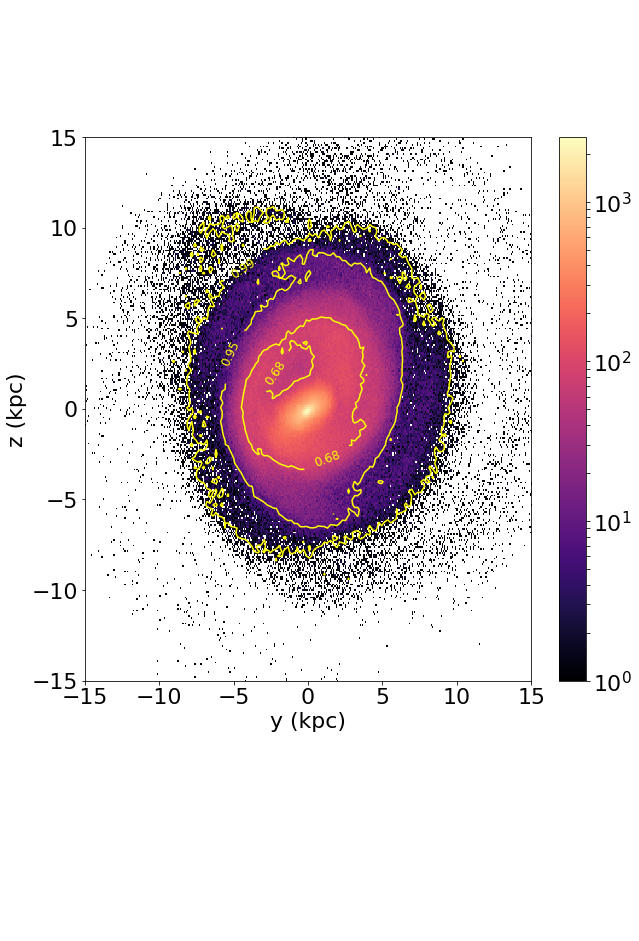

In [36]:
# Plotting Face On Disk

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# plot the particle density for LMC 
plt.hist2d(yn,zn, bins=500, norm=LogNorm(), cmap='magma')
plt.colorbar()

# calculate the 2D density of the data 
counts,xbins,ybins=np.histogram2d(yn,zn,bins=500,normed=LogNorm())

# make the contour plot
density_contour(yn,zn, 200, 200, ax=ax, colors=['yellow', 'yellow', 'yellow'])





# Add axis labels
plt.xlabel('y (kpc)', fontsize=22)
plt.ylabel('z (kpc)', fontsize=22)

#set axis limits
plt.ylim(-15,15)
plt.xlim(-15,15)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

ax.set_rasterized(True)
plt.savefig('LMC_faceon.eps', rasterized=True, dpi=350)

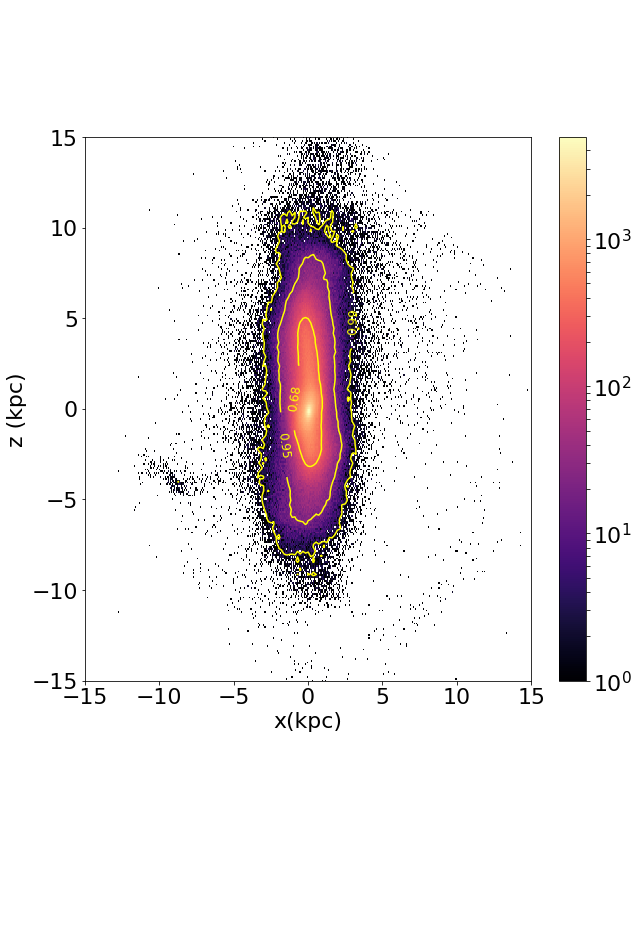

In [17]:
# Plotting Edge on Disk, view one

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# plot the particle density for LMC 
plt.hist2d(xn,zn, bins=500, norm=LogNorm(), cmap='magma')
plt.colorbar()

# calculate the 2D density of the data 
counts,xbins,ybins=np.histogram2d(xn,zn,bins=500,normed=LogNorm())

# make the contour plot
density_contour(xn,zn, 200, 200, ax=ax, colors=['yellow', 'yellow', 'yellow'])





# Add axis labels
plt.xlabel('x(kpc)', fontsize=22)
plt.ylabel('z (kpc)', fontsize=22)

#set axis limits
plt.ylim(-15,15)
plt.xlim(-15,15)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

ax.set_rasterized(True)
plt.savefig('LMC_edgeon.eps', rasterized=True, dpi=350)

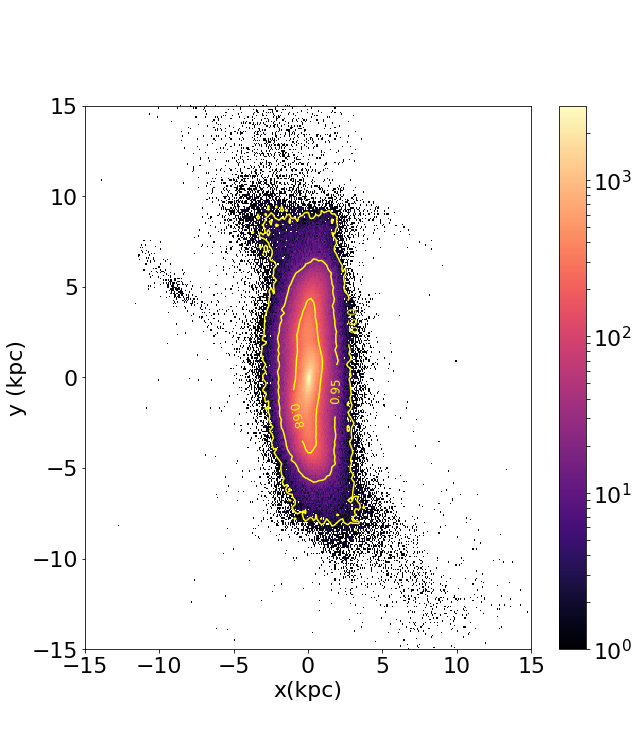

In [26]:
# Plotting Edge on Disk View 2 

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# plot the particle density for LMC 
plt.hist2d(xn,yn, bins=500, norm=LogNorm(), cmap='magma')
plt.colorbar()

# calculate the 2D density of the data 
counts,xbins,ybins=np.histogram2d(xn2,yn2,bins=500,normed=LogNorm())

# make the contour plot
density_contour(xn,yn, 200, 200, ax=ax, colors=['yellow', 'yellow', 'yellow'])


# Add axis labels
plt.xlabel('x(kpc)', fontsize=22)
plt.ylabel('y (kpc)', fontsize=22)

#set axis limits
plt.ylim(-15,15)
plt.xlim(-15,15)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

ax.set_rasterized(True)
plt.savefig('LMC_edgeonXY.eps', rasterized=True, dpi=350)

# Plotting Velocity Field

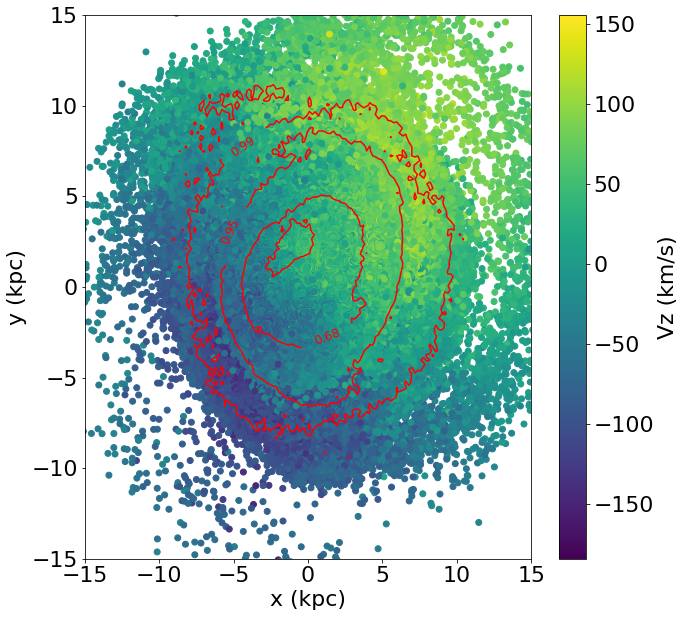

In [13]:
# Plot Vx Velocities - up out of the plane -  across disk face
# this should be close to the line-of-sight velocities. 
# But you could also take the 3D velocity vector (vy,vz,vx) and project it on the line of sight frame
# noting that "X" is out of the LMC disk plane. 

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)


# plot position of disk particles color coded by velocity along line of sight
plt.scatter(yn,zn,c=vxn)

#colorbar
cbar = plt.colorbar()
cbar.set_label(r'Vx (km/s)', size=22)


# calculate the 2D density of the data given
counts,xbins,ybins=np.histogram2d(yn,zn,bins=500,normed=LogNorm())

# make the contour plot
density_contour(yn,zn, 200, 200, ax=ax, colors=['red', 'red', 'red'])



# Add axis labels
plt.xlabel('x (kpc)', fontsize=22)
plt.ylabel('y (kpc)', fontsize=22)


#set axis limits
plt.ylim(-15,15)
plt.xlim(-15,15)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


# Selecting Smaller Volumes
Focusing on the northern spiral arm and the edge of the bar

In [57]:
# Currently selecting 1 x 1 kpc boxes in the YZ plane, which is aligned with the disk plane. 
# and allowing stars to be 1 kpc above or below the disk (i.e. in X direction)


# you could pick smaller volumes - but don't go below at least 3x the gravitational softening length
# Softening length is ~ 0.1 kpc for this simulation .  So don't pick volumes less than 0.3 kpc a side.


# ARM FIELDS 
##############

# volume 1 along arm
idx1 = np.where((yn < 4) & (yn > 3) & (zn >3) & (zn < 4) & (np.abs(xn) < 1))

# volume 2 along the arm 
idx2 = np.where((yn < 3) & (yn > 2) & (zn >3) & (zn < 4) & (np.abs(xn) < 1))

# volume 3 along the arm 
idx3 = np.where((yn < 2) & (yn > 1) & (zn >3) & (zn < 4) & (np.abs(xn) < 1))

# volume 4 along the arm 
idx4 = np.where((yn < 1) & (yn > 0) & (zn >3) & (zn < 4) & (np.abs(xn) < 1))

# volume 5 along the arm 
idx5 = np.where((yn < 0) & (yn > -1) & (zn >3) & (zn < 4) & (np.abs(xn) < 1))


# BAR FIELDS
##############

# volume 1 at the edge of the bar 
idx1b = np.where((zn > -1) & (zn < 0) & (yn >2) & (yn < 3) & (np.abs(xn) < 1))

# volume 2
idx2b = np.where((zn > 0) & (zn < 1) & (yn >2) & (yn < 3) & (np.abs(xn) < 1))

# volume 3
idx3b = np.where((zn > 1) & (zn < 2) & (yn >2) & (yn < 3) & (np.abs(xn) < 1))



7904


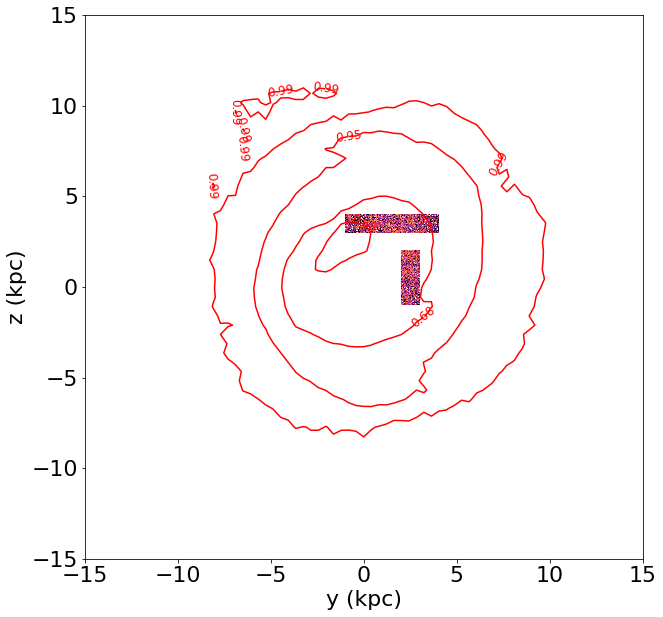

In [53]:
# Plot of the selected volumes

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)


# ARM FIELDS 

# Volume 1
plt.hist2d(yn[idx1],zn[idx1], bins=50, norm=LogNorm(), cmap='magma')

# Volume 2
plt.hist2d(yn[idx2],zn[idx2], bins=50, norm=LogNorm(), cmap='magma')

# Volume 3
plt.hist2d(yn[idx3],zn[idx3], bins=50, norm=LogNorm(), cmap='magma')

# Volume 4
plt.hist2d(yn[idx4],zn[idx4], bins=50, norm=LogNorm(), cmap='magma')

# Volume 5
plt.hist2d(yn[idx5],zn[idx5], bins=50, norm=LogNorm(), cmap='magma')


# BAR EDGE FIELDS
# Volume 1
plt.hist2d(yn[idx1b],zn[idx1b], bins=50, norm=LogNorm(), cmap='magma')
# Volume 2
plt.hist2d(yn[idx2b],zn[idx2b], bins=50, norm=LogNorm(), cmap='magma')
# Volume 3
plt.hist2d(yn[idx3b],zn[idx3b], bins=50, norm=LogNorm(), cmap='magma')


# calculate the 2D density of the data given
counts,xbins,ybins=np.histogram2d(yn,zn,bins=100,normed=LogNorm())

# make the contour plot
density_contour(yn,zn, 100, 100, ax=ax, colors=['red', 'red', 'red'])



# Add axis labels
plt.xlabel('y (kpc)', fontsize=22)
plt.ylabel('z (kpc)', fontsize=22)

#set axis limits
plt.ylim(-15,15)
plt.xlim(-15,15)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# Determining 3D Velocities and Dispersion in each volume

Mean Vel across disk 78.23194412175093
Std deviation 29.09985045059288

Mean Vel in Arm Vol 1  79.20992329375092
Std deviation 23.195656906115577

Mean Vel in Arm Vol 2  71.28382614505449
Std deviation 23.115064148620853

Mean Vel in Arm Vol 3  67.34484336734066
Std deviation 21.125100867334563

Mean Vel in Arm Vol 4  69.72846554509889
Std deviation 20.859265062275995


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "



Mean Vel in Arm Vol 5  78.45047957527345
Std deviation 24.7172799451224


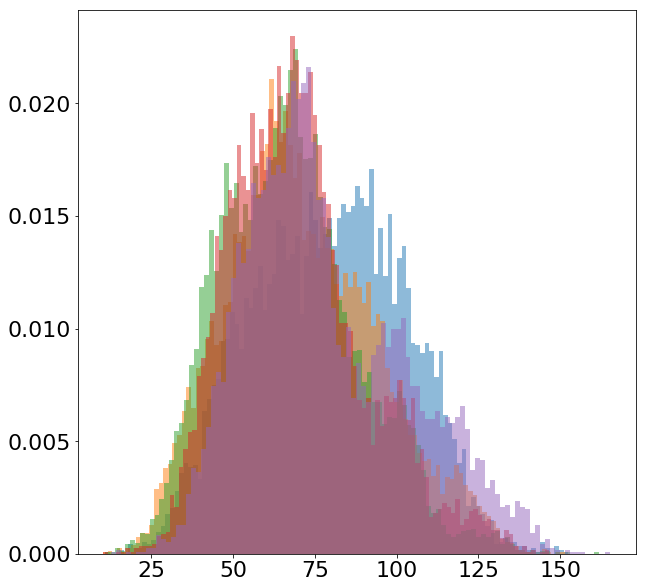

In [54]:
# Compute histograms of the 3D LMC-centric velocities in each volume. 
# ARM 

fig = plt.figure(figsize=(10,10))

ax = plt.subplot(111)

# total velocity 
vLMC = np.sqrt(vel[:,0]**2 + vel[:,1]**2 + vel[:,2]**2)
print("Mean Vel across disk", mean(vLMC))
print("Std deviation", np.std(vLMC))

print("")

# Arm Regions
print("Mean Vel in Arm Vol 1 ", np.mean(vLMC[idx1]))
print("Std deviation", np.std(vLMC[idx1]))
counts, bins, bars = plt.hist(vLMC[idx1],  bins=100, normed=True, alpha=0.5)
print("")

print("Mean Vel in Arm Vol 2 ", np.mean(vLMC[idx2]))
print("Std deviation", np.std(vLMC[idx2]))
counts, bins, bars = plt.hist(vLMC[idx2],  bins=100, normed=True, alpha=0.5)

print("")
print("Mean Vel in Arm Vol 3 ", np.mean(vLMC[idx3]))
print("Std deviation", np.std(vLMC[idx3]))
counts, bins, bars = plt.hist(vLMC[idx3],  bins=100, normed=True, alpha=0.5)

print("")
print("Mean Vel in Arm Vol 4 ", np.mean(vLMC[idx4]))
print("Std deviation", np.std(vLMC[idx4]))
counts, bins, bars = plt.hist(vLMC[idx4],  bins=100, normed=True, alpha=0.5)


print("")
print("Mean Vel in Arm Vol 5 ", np.mean(vLMC[idx5]))
print("Std deviation", np.std(vLMC[idx5]))
counts, bins, bars = plt.hist(vLMC[idx5],  bins=100, normed=True, alpha=0.5)


Mean Vel in Bar Vol 1  81.960680062009
Std deviation 21.594120682746855

Mean Vel in Bar Vol 2  73.01548910324603
Std deviation 19.788070219580753

Mean Vel in Bar Vol 3  65.9375338773682
Std deviation 19.352923652346323


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


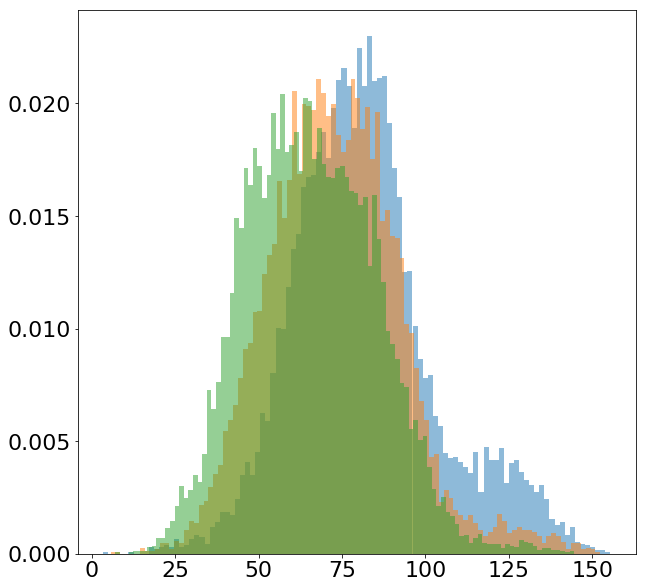

In [55]:
# Compute histograms of the 3D LMC-centric velocities in each volume. 
# BAR FIELD  

fig = plt.figure(figsize=(10,10))

ax = plt.subplot(111)


# Bar Regions
print("Mean Vel in Bar Vol 1 ", np.mean(vLMC[idx1b]))
print("Std deviation", np.std(vLMC[idx1b]))
counts, bins, bars = plt.hist(vLMC[idx1b],  bins=100, normed=True, alpha=0.5)
print("")

print("Mean Vel in Bar Vol 2 ", np.mean(vLMC[idx2b]))
print("Std deviation", np.std(vLMC[idx2b]))
counts, bins, bars = plt.hist(vLMC[idx2b],  bins=100, normed=True, alpha=0.5)

print("")
print("Mean Vel in Bar Vol 3 ", np.mean(vLMC[idx3b]))
print("Std deviation", np.std(vLMC[idx3b]))
counts, bins, bars = plt.hist(vLMC[idx3b],  bins=100, normed=True, alpha=0.5)